In [1]:
#Importing Required Libraries
import pandas as pd 
import numpy as np
import nltk
import re
import keras
import pandas, xgboost, numpy, string
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from pprint import pprint
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import decomposition, ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pandas import DataFrame

# Plotting tools
#import pyLDAvis
#import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Importing the dataset
df=pd.read_csv('reviews.csv')
df.head(5)
df.shape

(107018, 3)

# Text Pre-Processing

In [3]:
df.reset_index(inplace=True)
df.head(5)

,index,Id,Review,Label
0,0,0,good and interesting,5
1,1,1,"This class is very helpful to me. Currently, I...",5
2,2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,3,Easy to follow and includes a lot basic and im...,5
4,4,4,Really nice teacher!I could got the point eazl...,4


In [48]:
stop_words = set(stopwords.words("english"))

In [5]:
corpus = []
for i in range(0, df.shape[0]):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
    
    #Convert to lowercase
    text = text.lower()
    ##Convert to list from string
    text = text.split()
    ##Lemmatizing
    lm = WordNetLemmatizer() 
       
    
    text = [lm.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    corpus.append(text)

# Sentiment Analysis

In [49]:
corpus1=pd.DataFrame(corpus)
corpus1.head()

,0
0,good interesting
1,class helpful currently still learning class m...
2,like prof ta helpful discussion among student ...
3,easy follow includes lot basic important techn...
4,really nice teacher could got point eazliy v


In [7]:
text1=corpus1
text1.columns=['Review']
text1.head()

,Review
0,good interesting
1,class helpful currently still learning class m...
2,like prof ta helpful discussion among student ...
3,easy follow includes lot basic important techn...
4,really nice teacher could got point eazliy v


In [8]:
analyser=SentimentIntensityAnalyzer()

In [9]:
def score_speaker(speaker_df):
    df_dict = {}
    for i,response in speaker_df.iterrows():
        scorer = SentimentIntensityAnalyzer()
        scores = scorer.polarity_scores(response.Review)
        df_dict[i] = scores
    df = pd.DataFrame.from_dict(df_dict)
    df = df.T
    return df

In [10]:
df_score = score_speaker(text1)
df_score.head()

,compound,neg,neu,pos
0,0.6808,0.0,0.000,1.000
1,0.4215,0.0,0.781,0.219
2,0.8995,0.0,0.401,0.599
3,0.5719,0.0,0.598,0.402
4,0.4754,0.0,0.660,0.340


In [11]:
df_score['sent']=text1['Review']
df_score.head()

,compound,neg,neu,pos,sent
0,0.6808,0.0,0.000,1.000,good interesting
1,0.4215,0.0,0.781,0.219,class helpful currently still learning class m...
2,0.8995,0.0,0.401,0.599,like prof ta helpful discussion among student ...
3,0.5719,0.0,0.598,0.402,easy follow includes lot basic important techn...
4,0.4754,0.0,0.660,0.340,really nice teacher could got point eazliy v


In [12]:
df_group=df_score.groupby('sent').mean()
df_group.reset_index(inplace=True)
df_group.head()

,sent,compound,neg,neu,pos
0,,0.0000,0.000,0.000,0.000
1,ability self grade huge advantage moving pace ...,0.8658,0.000,0.359,0.641
2,able address necessary area relevant evidence ...,0.7506,0.000,0.686,0.314
3,able apply team company worked,0.0000,0.000,1.000,0.000
4,able audit class longer able take quiz test re...,0.0772,0.112,0.761,0.127


In [13]:
bins=[-1,0,0.6,1]
labels=['Negative','Neutral','Positive']
df_group['Type']=pd.cut(df_group['compound'],bins=bins,labels=labels)
df_group['Type'].value_counts()

Positive    62364
Neutral     23506
Negative     8602
Name: Type, dtype: int64

In [14]:
df_group.head()

,sent,compound,neg,neu,pos,Type
0,,0.0000,0.000,0.000,0.000,Negative
1,ability self grade huge advantage moving pace ...,0.8658,0.000,0.359,0.641,Positive
2,able address necessary area relevant evidence ...,0.7506,0.000,0.686,0.314,Positive
3,able apply team company worked,0.0000,0.000,1.000,0.000,Negative
4,able audit class longer able take quiz test re...,0.0772,0.112,0.761,0.127,Neutral


# Word Visualization

In [32]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words,ngram_range=(2,2),max_df=0.7,min_df=0.001).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


In [33]:
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]


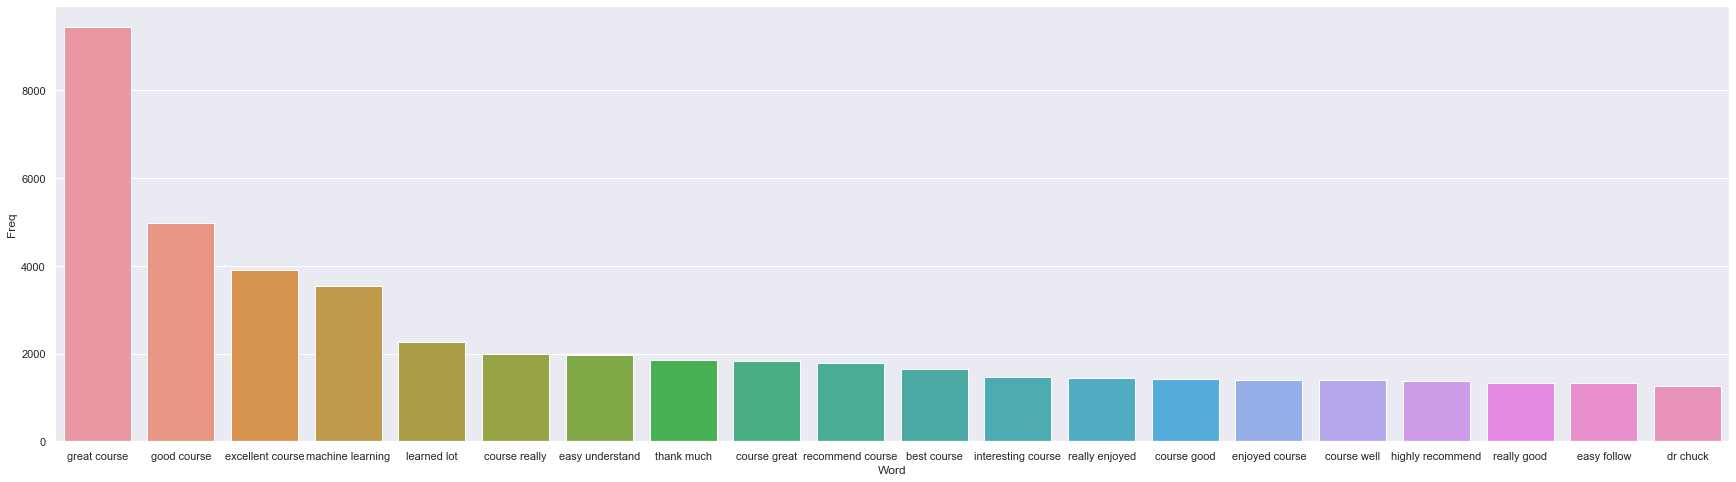

In [34]:
sns.set(rc={'figure.figsize':(30,8)})
sns.barplot(x="Word", y="Freq", data=top_df)

In [105]:
sent1=df_group['sent']
def get_top_n2_words(sent1, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(sent1)
    bag_of_words = vec1.transform(sent1)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(sent1, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)


               Bi-gram  Freq
0         great course  7092
1          good course  3897
2     excellent course  3678
3     machine learning  3458
4          learned lot  2089
5        course really  1946
6      easy understand  1854
7     recommend course  1756
8           thank much  1727
9         course great  1686
10         best course  1478
11         course well  1377
12      really enjoyed  1363
13         course good  1359
14    highly recommend  1338
15      enjoyed course  1335
16         easy follow  1274
17  interesting course  1252
18         really good  1207
19            dr chuck  1167


In [106]:
# Fit the tf-idf model
tfv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df = 0.001)
tfv


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=0.001, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [107]:
#execute the model on our corpus
tfidf_matrix =  tfv.fit_transform(sent1)

In [110]:
# tokenize and build vocab
tfmat = tfv.fit_transform(sent1)

In [109]:
feature_names=tfv.get_feature_names()
feature_names[:10]

['ability',
 'able',
 'absolute',
 'absolutely',
 'abstract',
 'academic',
 'accent',
 'access',
 'accessible',
 'account']

In [111]:
df_group['word_count']=df_group['sent'].apply(lambda x: len(str(x).split()))

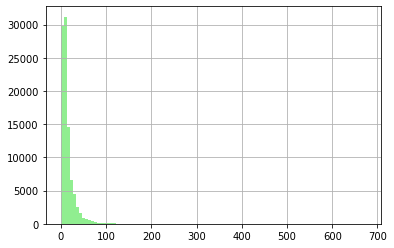

In [112]:
df_group['word_count'].hist(bins=100, color='lightgreen')

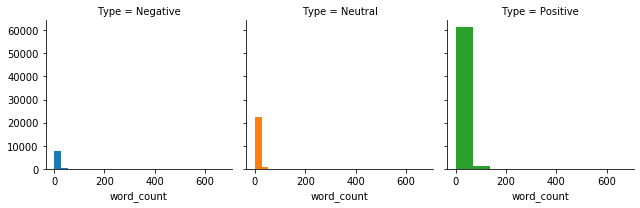

In [113]:
g = sns.FacetGrid(df_group, col='Type', hue='Type')
g.map(plt.hist,'word_count')

# Wordcloud for negative, neutral and positive reviews

Text(0.5, 1, 'Most frequent Positive words in Tweet dataset')

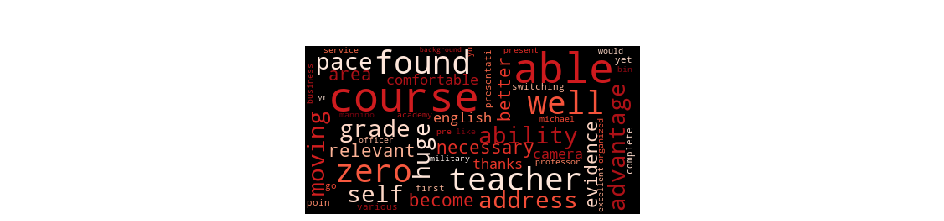

In [114]:
#Positive Words
wc = WordCloud(
                          background_color='black',
                          colormap="Reds",
                          stopwords=stop_words,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42,
                          )
# generate word cloud using text column
wc.generate(str(df_group[df_group['Type']=='Positive']['sent']))
# declare our figure 
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
fig.savefig("word1.png", dpi=900)
# add title to the graph
plt.title("Most frequent Positive words in Tweet dataset", fontsize=40,color='white')


Text(0.5, 1, 'Most frequent Negative words in Tweet dataset')

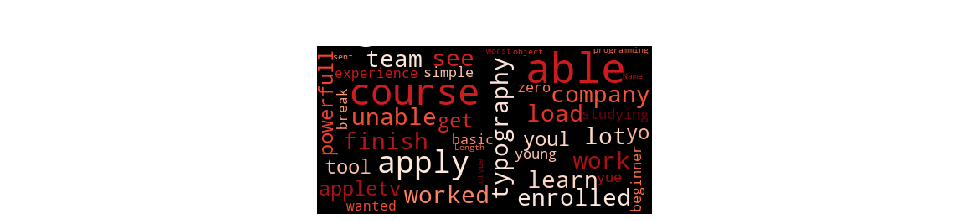

In [115]:
#Negative Words
wc = WordCloud(
                          background_color='black',
                          colormap="Reds",
                          stopwords=stop_words,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42,
                          )
# generate word cloud using text column
wc.generate(str(df_group[df_group['Type']=='Negative']['sent']))
# declare our figure 
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
fig.savefig("word1.png", dpi=900)
# add title to the graph
plt.title("Most frequent Negative words in Tweet dataset", fontsize=40,color='white')

Text(0.5, 1, 'Most frequent Neutral words in Tweet dataset')

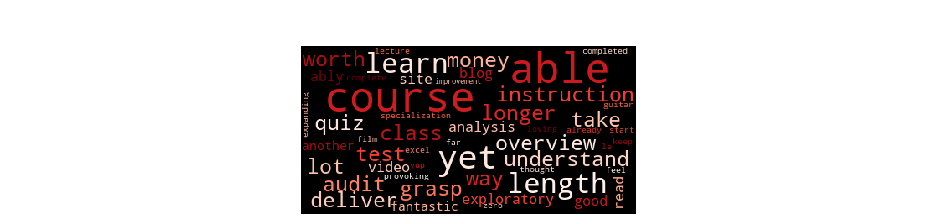

In [116]:
#Neutral Words
wc = WordCloud(
                          background_color='black',
                          colormap="Reds",
                          stopwords=stop_words,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42,
                          )
# generate word cloud using text column
wc.generate(str(df_group[df_group['Type']=='Neutral']['sent']))
# declare our figure 
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
fig.savefig("word1.png", dpi=900)
# add title to the graph
plt.title("Most frequent Neutral words in Tweet dataset", fontsize=40,color='white')

# Top Positive, Negative and Neutral bi-grams

In [125]:
#Positive Words
sent_pos=df_group[df_group['Type']=='Positive']['sent']
def get_top_n2_words(sent_pos, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(sent_pos)
    bag_of_words = vec1.transform(sent_pos)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(sent_pos, n=50)
top_pos = pd.DataFrame(top2_words)
top_pos.columns=["Bi-gram", "Freq"]
print(top_pos)


                Bi-gram  Freq
0          great course  6879
1      excellent course  3003
2      machine learning  2729
3           good course  2530
4          course great  1642
5       easy understand  1639
6         course really  1589
7      recommend course  1582
8            thank much  1556
9           learned lot  1455
10          best course  1451
11     highly recommend  1233
12       really enjoyed  1211
13          course well  1181
14          easy follow  1178
15       enjoyed course  1159
16             one best  1115
17          course good  1087
18             dr chuck  1022
19   interesting course   965
20          really good   916
21   great introduction   853
22       awesome course   850
23       amazing course   847
24      would recommend   835
25      well structured   830
26   highly recommended   817
27           would like   797
28         course would   776
29         course thank   748
30            andrew ng   747
31      course material   719
32  introd

In [124]:
#Neutral Words
sent_neu=df_group[df_group['Type']=='Neutral']['sent']
def get_top_n2_words(sent_neu, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(sent_neu)
    bag_of_words = vec1.transform(sent_neu)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(sent_neu, n=50)
top_neu = pd.DataFrame(top2_words)
top_neu.columns=["Bi-gram", "Freq"]
print(top_neu)

                   Bi-gram  Freq
0              good course  1316
1         excellent course   657
2         machine learning   598
3              learned lot   466
4        good introduction   404
5              nice course   350
6             data science   302
7              really good   277
8            course really   268
9       interesting course   262
10             course good   245
11     introductory course   223
12         easy understand   206
13            great course   193
14          well explained   186
15           useful course   184
16             course give   182
17         course material   181
18              learnt lot   180
19             course well   179
20         course beginner   177
21            course learn   175
22          course content   171
23          enjoyed course   167
24         well structured   167
25              lot course   159
26              thank much   158
27          course learned   153
28         looking forward   150
29        

In [127]:
#Negative Words
sent_neg=df_group[df_group['Type']=='Negative']['sent']
def get_top_n2_words(sent_neg, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(sent_neg)
    bag_of_words = vec1.transform(sent_neg)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(sent_neg, n=50)
top_neg = pd.DataFrame(top2_words)
top_neg.columns=["Bi-gram", "Freq"]
print(top_neg)

                   Bi-gram  Freq
0              learned lot   168
1         machine learning   131
2            course really    89
3               waste time    81
4              take course    81
5           course content    80
6          course material    78
7             data science    75
8              peer review    71
9       informative course    67
10             course give    64
11              little bit    61
12               learn lot    60
13           video lecture    59
14   course specialization    58
15              lot course    58
16         looking forward    57
17         complete course    57
18  programming assignment    56
19           course helped    55
20              high level    53
21             good course    51
22            first course    49
23             week course    47
24            basic course    47
25             course need    47
26           final project    47
27        discussion forum    46
28            found course    44
29     int

## Predictive Modelling

In [57]:
bins=[0,2,5]
labels=[0,1]
df_class = df
df_class['Type']=pd.cut(df['Label'],bins=bins,labels=labels)
df_class['Type'].value_counts()

1    102298
0      4720
Name: Type, dtype: int64

In [58]:
corpus[18]

'video presented french could translated english'

In [59]:
cv = cv = CountVectorizer(max_features = 4000, ngram_range=(1, 3))

In [65]:
X = cv.fit_transform(corpus).toarray()
y = df['Label']

In [66]:
print(X.shape)
print(y.shape)

(107018, 4000)
(107018,)


In [67]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.30, random_state = 0)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [68]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(74912, 4000) (32106, 4000)
(74912,) (32106,)


#### Naive Bayes Algorithm

In [69]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [70]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [71]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 547,  105,   48,   28,    3],
       [ 430,  129,   86,   25,    4],
       [ 867,  337,  201,   76,   32],
       [2454, 1076, 1065,  381,  464],
       [9005, 3523, 4208, 1111, 5901]], dtype=int64)

In [72]:
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.2229801283249237


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
Classifier_Scores = {}
Classifier_Scores.update({'Naive Bayes Algorithm':[accuracy_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred)]})

#### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(random_state=0)
classifier_LR.fit(X_train,y_train)

C:\Users\nikhi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
# Predicting the Test set results
y_pred = classifier_LR.predict(X_test)

In [31]:
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 2188,   423],
       [  343, 25388]], dtype=int64)

In [32]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.972972972972973
0.9836116384487235


In [33]:
Classifier_Scores.update({'Logistic Regression':[accuracy_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred)]})

#### Random Forest Classifier

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 50,random_state = 0,verbose= 0)
rf_model = rf.fit(X_train, y_train)

In [35]:
y_pred = rf_model.predict(X_test)

In [36]:
confusion_matrix(y_test, y_pred)

array([[ 1856,   755],
       [  303, 25428]], dtype=int64)

In [37]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.9626702420436102
0.9711644960470535


In [38]:
Classifier_Scores.update({'Random Forest':[accuracy_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred)]})

#### XG Boost Classifier 

In [39]:
import xgboost
xg_classifier = xgboost.XGBClassifier(n_estimators=50, verbose=4)
xg_model = xg_classifier.fit(X_train, y_train)

In [40]:
y_pred = xg_model.predict(X_test)

In [41]:
confusion_matrix(y_test, y_pred)

array([[    1,  2610],
       [    0, 25731]], dtype=int64)

In [42]:
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.907910521487545
0.9079072721498889


In [43]:
Classifier_Scores.update({'XG Boost':[accuracy_score(y_test, y_pred),recall_score(y_test, y_pred),precision_score(y_test, y_pred),f1_score(y_test, y_pred)]})

In [44]:
Classifier_Scores

{'Naive Bayes Algorithm': [0.5554301037329757,
  0.5180910186156776,
  0.9852191264503732,
  0.679079007691916],
 'Logistic Regression': [0.972972972972973,
  0.9866697757568691,
  0.9836116384487235,
  0.9851383337860387],
 'Random Forest': [0.9626702420436102,
  0.9882243208581089,
  0.9711644960470535,
  0.9796201410024271],
 'XG Boost': [0.907910521487545, 1.0, 0.9079072721498889, 0.9517310252996005]}

#### Comparing Classifier Performances

In [45]:
Classifier_Scores=pd.DataFrame(Classifier_Scores)
Classifier_Scores.rename({0:'Accuracy',1:'Recall',2:'Precision',3:'F1-Score'},inplace=True)

In [46]:
Classifier_Scores

,Naive Bayes Algorithm,Logistic Regression,Random Forest,XG Boost
Accuracy,0.555430,0.972973,0.962670,0.907911
Recall,0.518091,0.986670,0.988224,1.000000
Precision,0.985219,0.983612,0.971164,0.907907
F1-Score,0.679079,0.985138,0.979620,0.951731


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

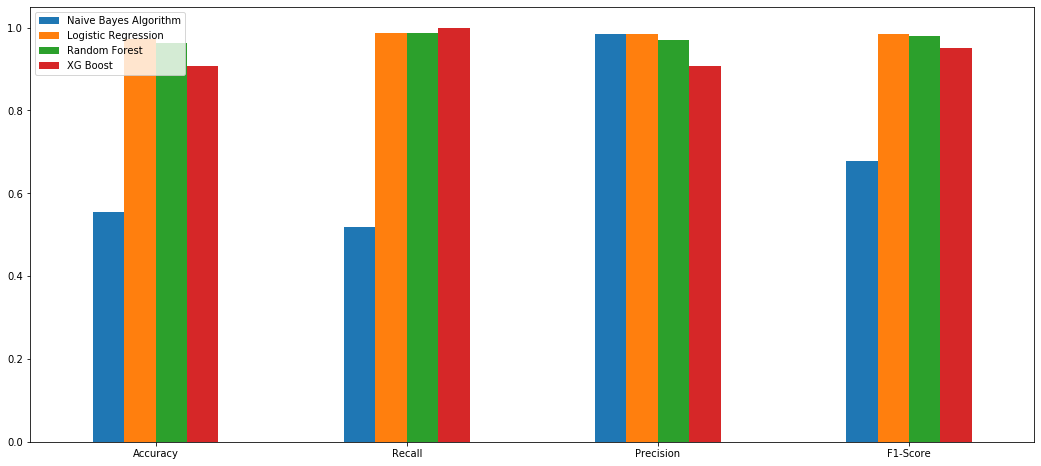

In [47]:
Classifier_Scores.plot.bar(figsize=(18,8))
plt.xticks(rotation=0)

# Topic Modelling

In [6]:
new_words = ['also', 'like', 'lecture', 'could', 'would', 'much', 'take', 'many', 'bit', 'little', 'lot', 'make', 'one', 
             'coursera', 'time', 'really', 'get', 'know', 'thing', 'way', 'made', 'first', 'give', 'want']
stop_words = stop_words.union(new_words)

In [7]:
corpus_tm = []
for i in range(0, df.shape[0]):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
    
    #Convert to lowercase
    text = text.lower()
    ##Convert to list from string
    text = text.split()
    ##Lemmatizing
    lm = WordNetLemmatizer() 
       
    
    text = [lm.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    corpus_tm.append(text)

In [8]:
NUM_TOPICS = 5

vectorizer = CountVectorizer(max_df=0.9, 
                             min_df=10,
                             stop_words=stop_words,
                             token_pattern='[a-zA-Z]{3,}')
data_vectorized = vectorizer.fit_transform(corpus_tm)

In [9]:
print(data_vectorized.shape)

(107018, 5567)


In [10]:
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, 
                                      max_iter=10, 
                                      learning_method='online',
                                     random_state=123)

lda_Z = lda_model.fit_transform(data_vectorized)

print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

(107018, 5)


In [11]:
#Function to print topic and top 8 words in the topic
def print_topics(model, vectorizer, top_n=8):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        
        print([(vectorizer.get_feature_names()[i], topic[i])
        #sorting in descending order
               for i in topic.argsort()[:-top_n - 1:-1]])
        
 
print_topics(lda_model, vectorizer)

Topic 0:
[('assignment', 8351.206388870482), ('programming', 5797.620464262469), ('python', 4922.758222395821), ('course', 4604.427504533347), ('quiz', 3196.8501228861383), ('project', 2952.546607738915), ('week', 2817.0216717784947), ('nice', 2539.635073830825)]
Topic 1:
[('course', 27808.195647419347), ('good', 12969.801530127206), ('learn', 6841.043359288533), ('topic', 4277.70570577831), ('basic', 3854.501173375825), ('beginner', 3797.555521428051), ('understanding', 3051.8031839846703), ('help', 2901.516077973688)]
Topic 2:
[('course', 37725.61369082345), ('great', 26116.354790975245), ('thank', 8507.278600476673), ('thanks', 6481.36206659627), ('professor', 5741.837531209231), ('well', 5381.6478750389115), ('interesting', 4984.426881023664), ('excellent', 4971.4511323228435)]
Topic 3:
[('course', 12049.711208559596), ('learning', 5613.928929520807), ('best', 5148.316872457493), ('machine', 3643.501740792972), ('data', 3571.5169166096293), ('awesome', 3402.702174427105), ('introdu

In [12]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

tf_feature_names = vectorizer.get_feature_names()

no_top_words = 10
topic_df = display_topics(lda_model, tf_feature_names, no_top_words)
topic_df

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,assignment,8351.2,course,27808.2,course,37725.6,course,12049.7,course,7816.0
1,programming,5797.6,good,12969.8,great,26116.4,learning,5613.9,easy,5337.2
2,python,4922.8,learn,6841.0,thank,8507.3,best,5148.3,understand,5285.4
3,course,4604.4,topic,4277.7,thanks,6481.4,machine,3643.5,good,5080.9
4,quiz,3196.9,basic,3854.5,professor,5741.8,data,3571.5,teacher,5044.7
5,project,2952.5,beginner,3797.6,well,5381.6,awesome,3402.7,clear,4386.1
6,week,2817.0,understanding,3051.8,interesting,4984.4,introduction,3305.6,well,3765.3
7,nice,2539.6,help,2901.5,excellent,4971.5,good,3278.4,informative,3257.3
8,class,2351.9,knowledge,2681.9,useful,4839.0,highly,3135.2,even,3200.0
9,question,2254.4,student,2659.3,learned,4594.3,life,2809.4,video,2894.8
